In [1]:
from pathlib import Path
from typing import Union, Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from dlsvm.models import DnnSvm
from dlsvm.tools import build_model, label_2_pn

In [2]:
out = Path('./0518_iris_svm')
if not out.exists():
    out.mkdir(parents=True)

In [3]:
sns.set()

### Load dataset

In [4]:
iris = datasets.load_iris()
X = iris.data.astype(np.float32)
y = iris.target.astype(np.float32)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_, X_train_val, y_train_, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
y_train_ = label_2_pn(y_train_)
y_train_val = label_2_pn(y_train_val)

### Build model

In [7]:
dlsvm = build_model(
    n_class=len(iris.target_names),
    n_in=len(iris.data[0]),
    n_h=32,
    activation='relu',
    kernel_initializer='he_uniform',
    penalty=0.5,
    softmax=False
)

In [8]:
batch_size = 12
epochs = 100
learning_rate = 1e-3
patience = 5
loss = dlsvm.loss_l2_svm

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dlsvm.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [10]:
es_cb = tfk.callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, mode='auto'
)
tb_cb = tfk.callbacks.TensorBoard(log_dir=str(out))
cl_cb = tfk.callbacks.CSVLogger(
    str(out.joinpath('train.log.csv')), separator=',', append=False
)
cp_cb = tfk.callbacks.ModelCheckpoint(
    str(out.joinpath('model.weights.h5')), monitor='val_acc', verbose=0,
    save_best_only=True, save_weights_only=False, mode='auto', period=1
)

### Train model

In [11]:
history = dlsvm.fit(
    *(X_train_, y_train_),
    validation_data=(X_train_val, y_train_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tb_cb, cl_cb, cp_cb]
)

Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 1s 13ms/sample - loss: 4.8304 - acc: 0.3333 - val_loss: 4.0403 - val_acc: 0.3333
Epoch 2/100
96/96 [==============================] - 0s 779us/sample - loss: 3.4880 - acc: 0.3333 - val_loss: 2.9875 - val_acc: 0.3333
Epoch 3/100
96/96 [==============================] - 0s 693us/sample - loss: 2.4942 - acc: 0.3333 - val_loss: 2.1453 - val_acc: 0.3333
Epoch 4/100
96/96 [==============================] - 0s 537us/sample - loss: 1.7236 - acc: 0.3333 - val_loss: 1.5191 - val_acc: 0.3333
Epoch 5/100
96/96 [==============================] - 0s 667us/sample - loss: 1.1639 - acc: 0.3333 - val_loss: 1.0792 - val_acc: 0.3333
Epoch 6/100
96/96 [==============================] - 0s 874us/sample - loss: 0.8214 - acc: 0.4271 - val_loss: 0.7688 - val_acc: 0.5417
Epoch 7/100
96/96 [==============================] - 0s 569us/sample - loss: 0.5725 - acc: 0.6771 - val_loss: 0.5639 - val_acc: 0.5417
Epoch 8/100


In [12]:
df_result = pd.DataFrame(history.history)

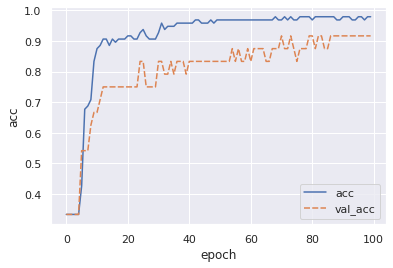

In [13]:
sns.lineplot(data=df_result[['acc', 'val_acc']])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(out.joinpath('acc_logs.pdf'))

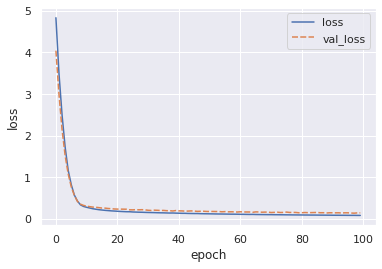

In [14]:
sns.lineplot(data=df_result[['loss', 'val_loss']])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(out.joinpath('loss_logs.pdf'))

In [15]:
dlsvm.load_weights(str(out.joinpath('model.weights.h5')))

In [16]:
dlsvm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


### Performance of model

In [17]:
df_train = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_train), axis=-1), y_true=y_train, output_dict=True)
)
print('Train perfomance of model')
print(df_train)
df_train.to_csv(out.joinpath('train-performance.csv'))

Train perfomance of model
            0.0        1.0        2.0   micro avg   macro avg  weighted avg
f1-score    1.0   0.936709   0.938272    0.958333    0.958327      0.958314
precision   1.0   0.973684   0.904762    0.958333    0.959482      0.960056
recall      1.0   0.902439   0.974359    0.958333    0.958933      0.958333
support    40.0  41.000000  39.000000  120.000000  120.000000    120.000000


In [18]:
df_test = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_test), axis=-1), y_true=y_test, output_dict=True)
)
print('Test perfomance of model')
print(df_test)
df_test.to_csv(out.joinpath('test-performance.csv'))

Test perfomance of model
            0.0  1.0   2.0  micro avg  macro avg  weighted avg
f1-score    1.0  1.0   1.0        1.0        1.0           1.0
precision   1.0  1.0   1.0        1.0        1.0           1.0
recall      1.0  1.0   1.0        1.0        1.0           1.0
support    10.0  9.0  11.0       30.0       30.0          30.0


In [19]:
np.argmax(dlsvm.predict(X_train), axis=-1)

array([0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2,
       2, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2, 2,
       1, 2, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 1,
       0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2,
       1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [20]:
np.argmax(dlsvm.predict(X_test), axis=-1)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])